# Augmentations on hand gestures dataset

#### Import libraries

In [3]:
import glob
import itertools
import json
import os
import re

import mrob
import numpy as np
import open3d as o3d

import matplotlib.pyplot as plt

import utils.utils as utils
import utils.utils_o3d as utils_o3d

#### Set filenames

In [11]:
DATA_DIR = "data"
SET_DIR = "set_5_rotate"
# front, right, left (really not matter)
CAMERAS_DIR = ("cam_center", "cam_right", "cam_left")

CALIBRATION_DIR = os.path.join(DATA_DIR, "calib_params")
CALIBRATION_INTRINSIC = {
    "cam_center": "1m.json",
    "cam_right": "2s.json",
    "cam_left": "9s.json",
}
CALIBRATION_EXTRINSIC = {
    ("cam_center", "cam_right"): os.path.join("1-2", "calibration_blob.json"),
    ("cam_center", "cam_left"): os.path.join("1-9", "calibration_blob.json"),
    ("cam_right", "cam_left"): os.path.join("2-9", "calibration_blob.json"),
}

RENDER_OPTION = "render_option.json"

main_camera_index = 0

## Functional part

#### Read images

Map images indexes by timestamps

Get a list of indexes for each frame from main stream that are nearest by timestamps

`utils.find_timestamp`

`utils.map_nearest`

#### Read calibration

`utils.get_intrinsics`

`utils.get_extrinsics`

#### Transform Depth image on Color image

TODO (currently provided by dataset)

NOTE: better to pre-process this step rather to integrate in pipeline

#### Create Point clouds

NOTE: better to pre-process this step rather to integrate in pipeline

`utils_o3d.get_rgbd_images`

`utils_o3d.create_point_clouds`

#### Concatenate Point clouds

`utils_o3d.concatenate_point_clouds`

#### Supportive functions to get matrices

`utils.build_intrinsic_matrix`

`utils.build_extrinsic_matrix`

`utils.randomize_extrinsic`

#### Project Point clouds

`utils_o3d.filter_by_image_size`

`utils_o3d.project_point_clouds`

## Overall pipeline

Read images and calibration files

In [12]:
# list of [..., CAMERAS_DIR[i - 1]/depth/*.png, CAMERAS_DIR[i]/color/*.jpg, CAMERAS_DIR[i]/depth/*.png, ...]
images_paths = [sorted(glob.glob(os.path.join(DATA_DIR, SET_DIR, camera, type, '*')))
                for camera, type in itertools.product(CAMERAS_DIR, ('color', 'depth'))]
mapped_indexes = utils.map_nearest(images_paths, main_camera_index)

intrinsics_paths = [os.path.join(CALIBRATION_DIR, CALIBRATION_INTRINSIC[camera])
                    for camera in CAMERAS_DIR]
intrinsics = utils.get_intrinsics(intrinsics_paths)

extrinsics_paths = [os.path.join(CALIBRATION_DIR, CALIBRATION_EXTRINSIC[camera])
                    for camera in itertools.combinations(CAMERAS_DIR, 2)]
extrinsics = utils.get_extrinsics(extrinsics_paths)

render_option_path = os.path.join(DATA_DIR, RENDER_OPTION)

New view settings

In [13]:
angle = np.deg2rad(30)
z_target = 1.25

K = utils.build_intrinsic_matrix(*intrinsics[main_camera_index, 2:])
T = utils.build_extrinsic_matrix(angle, z_target)

# loc = np.array([0., -np.pi/2, 0., 1.3, 0., -1.8])
loc = np.array([0., 0., 0., 0., 0., 0.])
scale = np.array([0., 0., 0., 0., 0., 0.])
T_randomized = utils.randomize_extrinsic(T, loc, scale)

Renderer settings

In [14]:
*image_size, = map(int, intrinsics[main_camera_index, :2])
vis = utils_o3d.get_visualizer(image_size, render_option_path)

In [15]:
camera = o3d.camera.PinholeCameraParameters()

camera.extrinsic = np.linalg.inv(T_randomized)

to_filter = [1, 1, 0, 0, 0, 0]
camera.intrinsic = o3d.camera.PinholeCameraIntrinsic(
    *map(lambda val: int(val[1]) if to_filter[val[0]] else val[1],
         enumerate([*intrinsics[main_camera_index]]))
)

view_control = vis.get_view_control()

# Set background image
# image_background = np.zeros((*map(int, intrinsics[main_camera_index, 1::-1]), 3))
image_background = np.random.random(
    (*map(int, intrinsics[main_camera_index, 1::-1]), 3)
)

Create, Concatenate Point clouds and Project on new View

In [ ]:
# i = 50
# group = mapped_indexes[i]
# while True:
for group in mapped_indexes:
    paths = [''] * len(group)
    for i, index in enumerate(group):
        paths[i] = images_paths[i][index]

    rgbd_images = utils_o3d.get_rgbd_images(
        paths,
        depth_scale=1000,
        depth_trunc=2.0
    )

    point_clouds = utils_o3d.create_point_clouds(
        rgbd_images,
        intrinsics[::2],
        np.concatenate([[np.eye(4)], extrinsics[:len(CAMERAS_DIR) - 1]])
    )

    pc_concatenated = utils_o3d.concatenate_point_clouds(point_clouds)

    # Filter outliers
    pc_concatenated, _ = pc_concatenated.remove_radius_outlier(10, 0.01)

    # Option 1:
    # Render Point cloud
    vis.add_geometry(pc_concatenated)

    view_control.convert_from_pinhole_camera_parameters(camera, True)

    vis.poll_events()
    vis.update_renderer()
    rendered_image = np.asarray(vis.capture_screen_float_buffer(do_render=True))
    vis.clear_geometries()

    # Option 2:
    # Image recieved by manual projection without rendering
    image_projected = utils_o3d.project_point_clouds(pc_concatenated, K, T_randomized, *map(int, intrinsics[0, :2]))

    # Add background
    # image_background = np.asarray(o3d.io.read_image(paths[2 * main_camera_index])) / 255
    # image_background = np.random.random(rendered_image.shape)
    rendered_image_background = np.where(rendered_image == np.zeros(3), image_background, rendered_image)

    # plt.imsave(f"outputs/rendered_{str(group[0]).zfill(8)}.jpg", np.asarray(rendered_image))
    break

# import subprocess
# subprocess.run(["ffmpeg", "-y", "-framerate", "30", "-i", "outputs/rendered_%08d.jpg", "rendered.mp4"])

After everything is done the visualization window should be destroyed

In [ ]:
vis.destroy_window()

Plot rendered Point cloud

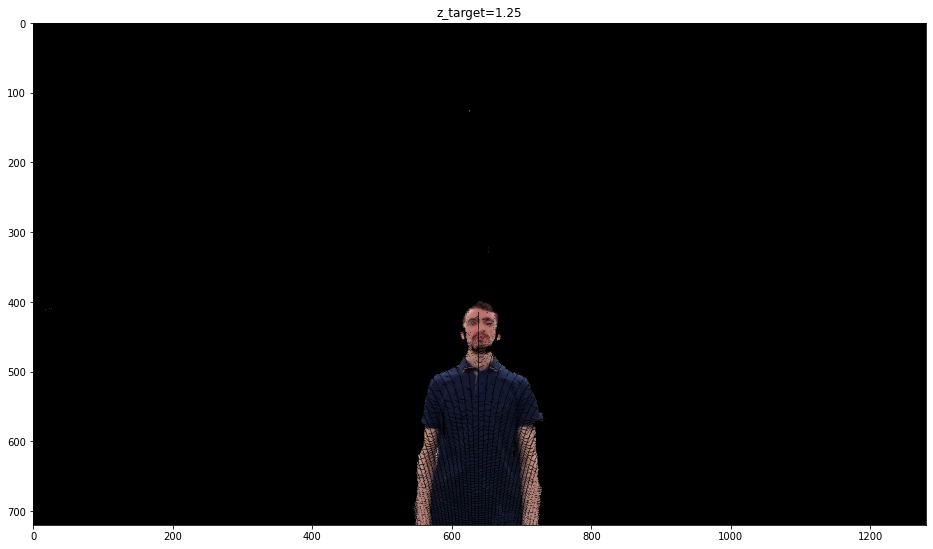

In [21]:
plt.figure(figsize=(16, 10))
plt.title(f"{z_target=}")
plt.imshow(rendered_image);
# plt.savefig(f"outputs/{z_target}_filtered.jpg", bbox_inches='tight')

Plot rendered Point cloud with Background

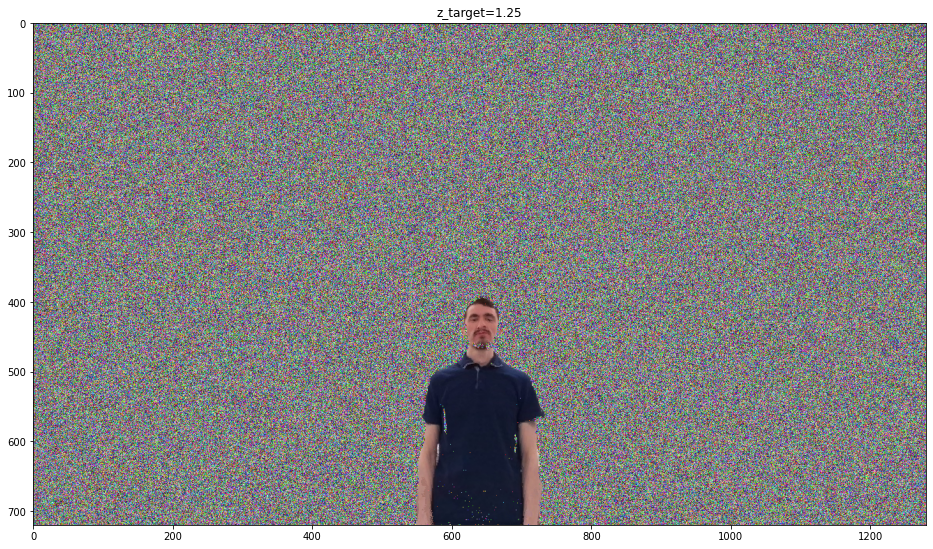

In [27]:
plt.figure(figsize=(16, 10))
plt.title(f"{z_target=}")
plt.imshow(rendered_image_background);
# plt.savefig(f"outputs/{z_target}_background.jpg", bbox_inches='tight')

Plot manual projected Point cloud

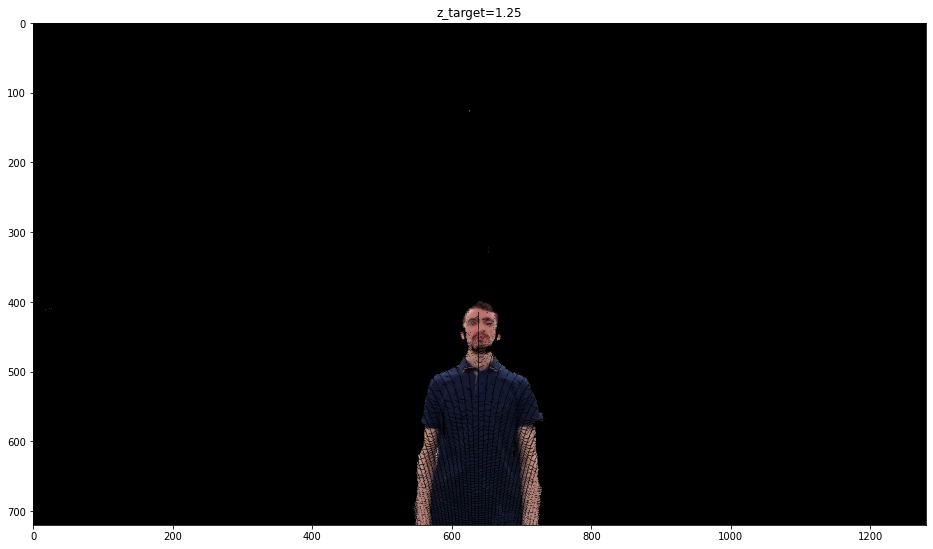

In [35]:
plt.figure(figsize=(16, 10))
plt.title(f"{z_target=}")
plt.imshow(image_projected);
# plt.savefig(f"outputs/{z_target}_filtered.jpg", bbox_inches='tight')

Plot image without transformation

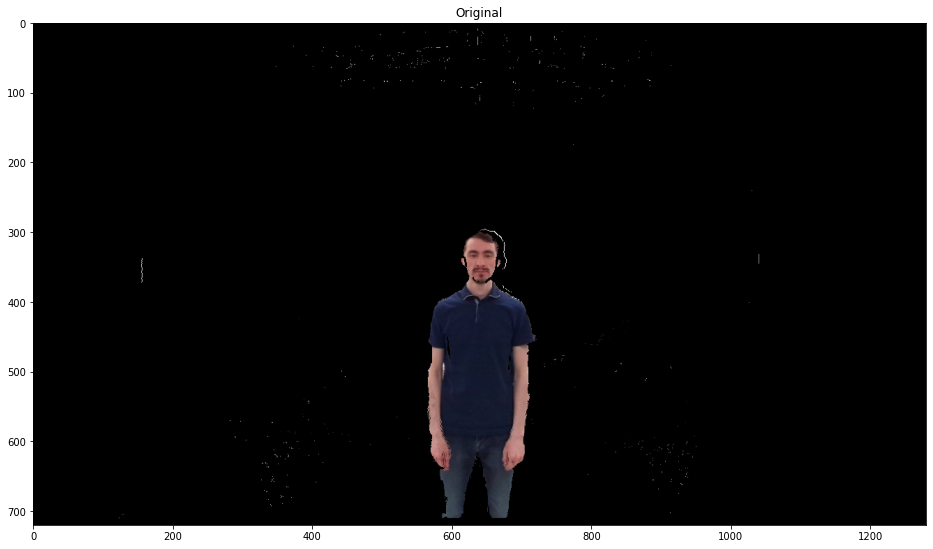

In [36]:
image_projected_orig = utils_o3d.project_point_clouds(pc_concatenated, K, np.eye(4), *map(int, intrinsics[0, :2]))

plt.figure(figsize=(16, 10))
plt.title("Original")
plt.imshow(image_projected_orig);
# plt.savefig("outputs/Original_filtered.jpg", bbox_inches='tight')

## Plotly visualization

Visualization of concatenated Point cloud

In [37]:
import plotly.graph_objects as go

In [38]:
depth_points = np.asarray(pc_concatenated.points)
colors_points = np.asarray(pc_concatenated.colors)

step = 10

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=depth_points[::step, 0],
            y=depth_points[::step, 1],
            z=depth_points[::step, 2],
            mode='markers',
            marker=dict(size=1, color=colors_points[::step])
        )
    ],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=True),
            yaxis=dict(visible=True),
            zaxis=dict(visible=True)
        )
    )
)
fig.show()